In [144]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import contextily as cx

from dotenv import load_dotenv
from census import Census
from itertools import chain
from matplotlib import pyplot as plt
from tqdm import tqdm

In [145]:
load_dotenv()
api_key = os.getenv("api_key")

# Notebook for Generating Supplemental Data for Community District 3

## Step 1: Load Census Tract and Block Geospatial Data

Geospatial data loaded via NYC Open Data and Tiger

In [146]:
# load 2010 to 2020 Census tract relationship files
df_tract_rel = pd.read_csv("_input/census_rel_file.txt", sep="|")
df_block_rel = pd.read_csv("_input/tab2010_tab2020_st36_ny.txt")

In [147]:
nyc_tracts = gpd.read_file(
    "https://data.cityofnewyork.us/resource/63ge-mke6.geojson?$limit=100000"
)
nyc_tracts.head()

,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,geometry
0,1843004.52241,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),10833.0439286,Manhattan,000100,MN0191,1,I,36061000100,1000100,MN01,1,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,1006116.58429,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5075.33199978,Manhattan,001401,MN0302,1,I,36061001401,1001401,MN03,14.01,"MULTIPOLYGON (((-73.98837 40.71645, -73.98754 ..."
2,1226206.24719,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4459.1560187,Manhattan,001402,MN0302,1,E,36061001402,1001402,MN03,14.02,"MULTIPOLYGON (((-73.98507 40.71908, -73.98423 ..."
3,2399276.86435,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),6391.92117449,Manhattan,001800,MN0302,1,I,36061001800,1001800,MN03,18,"MULTIPOLYGON (((-73.98985 40.72052, -73.98972 ..."
4,1740173.87581,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),5779.06260724,Manhattan,002201,MN0302,1,E,36061002201,1002201,MN03,22.01,"MULTIPOLYGON (((-73.97875 40.71993, -73.97879 ..."


In [148]:
# load 2010 tracts
nyc_tracts_2010 = gpd.read_file(
    "https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_36061_tract10.zip"
)
nyc_tracts_2010.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,061,027100,36061027100,271,Census Tract 271,G5020,S,192555,0,+40.8519392,-073.9342905,"POLYGON ((-73.93666 40.85045, -73.93634 40.851..."
1,36,061,012900,36061012900,129,Census Tract 129,G5020,S,404996,407508,+40.7650139,-073.9998117,"POLYGON ((-74.00827 40.76485, -74.00585 40.768..."
2,36,061,014401,36061014401,144.01,Census Tract 144.01,G5020,S,74319,0,+40.7752486,-073.9475520,"POLYGON ((-73.94937 40.77688, -73.94919 40.776..."
3,36,061,009900,36061009900,99,Census Tract 99,G5020,S,1007102,1125670,+40.7523775,-074.0083669,"POLYGON ((-73.99843 40.75556, -73.99866 40.755..."
4,36,061,014601,36061014601,146.01,Census Tract 146.01,G5020,S,74328,0,+40.7771918,-073.9521610,"POLYGON ((-73.94987 40.7762, -73.95034 40.7755..."


In [149]:
# select all tracts in Community District 3
# number via sector
# assign differently for 2010 vs. 2020
cb3_sectors = {
    2020: {
        1: ["004200", "004002", "004001", "003602", "003800"],
        2: ["003400", "003200", "003002"],
        3: ["002800", "002602", "002601", "002202"],
        4: ["003001", "002201"],
        5: ["001200", "001001", "001402", "001401"],
        6: ["000600", "000201", "000202"],
        7: ["000800", "002700", "002500"],
        8: ["002902", "001600"],
        9: ["001800", "003601"],
        10: ["002400", "002000", "001002"],
    },
    2010: {
        1: ["004200", "004000", "003602", "003800"],
        2: ["003400", "003200", "003002"],
        3: ["002800", "002602", "002601", "002202"],
        4: ["003001", "002201"],
        5: ["001200", "001001", "001402", "001401"],
        6: ["000600", "000201", "000202"],
        7: ["000800", "002700", "002500"],
        8: ["002900", "001600"],
        9: ["001800", "003601"],
        10: ["002400", "002000", "001002"],
    },
}

cb3_tracts = list(chain.from_iterable(cb3_sectors[2020].values()))

In [150]:
# subset rel file to CB3
# create formatted GEOID variables
df_tract_rel["GEOID_form_20"] = (
    df_tract_rel["GEOID_TRACT_20"].astype(str).str.pad(11, side="left", fillchar="0")
)
df_tract_rel["GEOID_form_10"] = (
    df_tract_rel["GEOID_TRACT_10"].astype(str).str.pad(11, side="left", fillchar="0")
)
cb3_tract_rel = df_tract_rel[
    (df_tract_rel["GEOID_form_20"].str.slice(-6).isin(cb3_tracts))
    & (df_tract_rel["GEOID_form_20"].str.slice(0, 5) == "36061")
]
cb3_tracts_2010 = cb3_tract_rel["GEOID_form_10"].str.slice(5).unique()

cb3_tracts_by_year = {2020: cb3_tracts, 2010: cb3_tracts_2010}

In [151]:
# check tracts that changed
cb3_tract_rel[cb3_tract_rel["GEOID_TRACT_20"] != cb3_tract_rel["GEOID_TRACT_10"]]

,OID_TRACT_20,GEOID_TRACT_20,NAMELSAD_TRACT_20,AREALAND_TRACT_20,AREAWATER_TRACT_20,MTFCC_TRACT_20,FUNCSTAT_TRACT_20,OID_TRACT_10,GEOID_TRACT_10,NAMELSAD_TRACT_10,AREALAND_TRACT_10,AREAWATER_TRACT_10,MTFCC_TRACT_10,FUNCSTAT_TRACT_10,AREALAND_PART,AREAWATER_PART,GEOID_form_20,GEOID_form_10
77768,2079015681794567,36061002902,Census Tract 29.02,123830,0,G5020,S,20740460864031,36061002900,Census Tract 29,273358,0,G5020,S,123830,0,36061002902,36061002900
77780,2079019627440616,36061004001,Census Tract 40.01,91742,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,91742,0,36061004001,36061004000
77781,2079015681794515,36061004002,Census Tract 40.02,86591,0,G5020,S,20740460873500,36061004000,Census Tract 40,178333,0,G5020,S,86591,0,36061004002,36061004000


In [152]:
# create a gdf of just cb3
cb3_gdf = nyc_tracts[nyc_tracts["cdta2020"] == "MN03"].copy()
print(cb3_gdf.shape[0], len(cb3_tracts))

31 31


In [153]:
# create a gdf of just cb3 for 2010
nyc_tracts_2010["ct2010"] = nyc_tracts_2010["GEOID10"].str.slice(5)
cb3_gdf_2010 = nyc_tracts_2010[nyc_tracts_2010["ct2010"].isin(cb3_tracts_by_year[2010])]
print(cb3_gdf_2010.shape[0], len(cb3_tracts_by_year[2010]))

30 30


In [154]:
# assign sectors, store in sector variable
cb3_gdf["sectors"] = np.select(
    [cb3_gdf["ct2020"].isin(cb3_sectors[2020][i]) for i in cb3_sectors[2020].keys()],
    list(cb3_sectors[2020].keys()),
)
cb3_gdf.head()

cb3_gdf_2010["sectors"] = np.select(
    [
        cb3_gdf_2010["ct2010"].isin(cb3_sectors[2010][i])
        for i in cb3_sectors[2010].keys()
    ],
    list(cb3_sectors[2010].keys()),
)
cb3_gdf_2010.head()

/opt/anaconda3/envs/cb3-census/lib/python3.13/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,ct2010,sectors
10,36,061,001401,36061001401,14.01,Census Tract 14.01,G5020,S,93510,0,+40.7151603,-073.9873314,"POLYGON ((-73.98608 40.7144, -73.98716 40.7143...",001401,5
34,36,061,000201,36061000201,2.01,Census Tract 2.01,G5020,S,90205,88971,+40.7098991,-073.9855836,"POLYGON ((-73.98455 40.7095, -73.98404 40.7048...",000201,6
83,36,061,002500,36061002500,25,Census Tract 25,G5020,S,133767,107616,+40.7085998,-073.9978104,"POLYGON ((-73.996 40.7089, -73.99365 40.7047, ...",002500,7
88,36,061,002202,36061002202,22.02,Census Tract 22.02,G5020,S,56090,0,+40.7212601,-073.9811422,"POLYGON ((-73.97875 40.71993, -73.97973 40.720...",002202,3
98,36,061,003400,36061003400,34,Census Tract 34,G5020,S,160257,0,+40.7290092,-073.9814618,"POLYGON ((-73.978 40.72943, -73.97854 40.72875...",003400,2


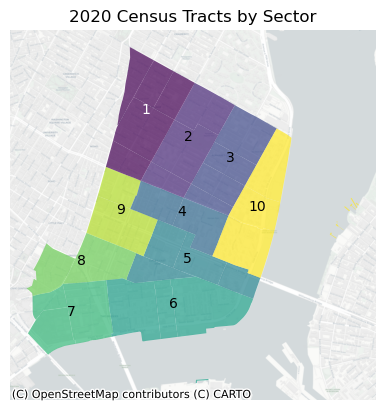

In [155]:
# create sector map
cb3_gdf = cb3_gdf.to_crs(2263)
cb3_gdf_diss = cb3_gdf.dissolve(by="sectors").to_crs(2263).reset_index()
cb3_gdf_diss["coords"] = cb3_gdf_diss["geometry"].centroid.apply(lambda x: x.coords[0])
ax = cb3_gdf.plot(column="sectors", alpha=0.7)
for idx, row in cb3_gdf_diss.iterrows():
    color = "black"
    if row["sectors"] == 1:
        color = "white"
    plt.annotate(
        text=row["sectors"], xy=row["coords"], horizontalalignment="center", color=color
    )
cx.add_basemap(ax, zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron)
plt.title("2020 Census Tracts by Sector")
ax.set_axis_off();

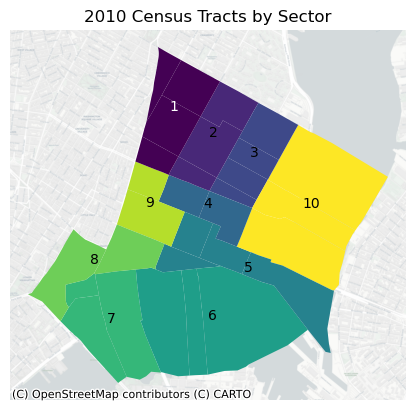

In [156]:
# create 2010 sector map
cb3_gdf_2010 = cb3_gdf_2010.to_crs(2263)
cb3_gdf_2010_diss = cb3_gdf_2010.dissolve(by="sectors").reset_index()
cb3_gdf_2010_diss["coords"] = cb3_gdf_2010_diss["geometry"].centroid.apply(
    lambda x: x.coords[0]
)
ax = cb3_gdf_2010.plot(column="sectors")
for idx, row in cb3_gdf_2010_diss.iterrows():
    color = "black"
    if row["sectors"] == 1:
        color = "white"
    plt.annotate(
        text=row["sectors"], xy=row["coords"], horizontalalignment="center", color=color
    )
cx.add_basemap(ax, zoom=16, crs=cb3_gdf_diss.crs, source=cx.providers.CartoDB.Positron)
plt.title("2010 Census Tracts by Sector")
ax.set_axis_off();

## Step 2: Load Data from the Decennial Census (2020 and 2010)

In [157]:
if api_key == '':
    census = Census()
else:
    census = Census(api_key)

In [158]:
# decennial census columns by year
# loading data for the 2020 and 2010 decennial census
dec_dict = {
    2020: {
        "P1_001N": "total",
        "P2_002N": "hispanic_latino",
        "P2_005N": "nh_white",
        "P2_006N": "nh_black",
        "P2_007N": "nh_aian",
        "P2_008N": "nh_asian",
        "P2_009N": "nh_nhpi",
        "P2_010N": "nh_other",
        "P2_011N": "nh_multi",
    },
    2010: {
        "P001001": "total",
        "P002002": "hispanic_latino",
        "P002005": "nh_white",
        "P002006": "nh_black",
        "P002007": "nh_aian",
        "P002008": "nh_asian",
        "P002009": "nh_nhpi",
        "P002010": "nh_other",
        "P002011": "nh_multi",
    },
}

In [159]:
# get 2020,2010 census data first
dec_gdf_list = []
for yr in [2020, 2010]:
    print(f'Loading data for decennial census {yr}')
    dec_gdf_yr = census.pl.get(
        (["NAME", "GEO_ID"] + list(dec_dict[yr].keys())),
        geo={
            "for": f"tract:{','.join(cb3_tracts)}",
            "in": f"state:36 county:061",
        },
        year=yr,
    )
    dec_gdf_list += [
        pd.DataFrame(dec_gdf_yr).rename(columns=dec_dict[yr]).assign(year=yr)
    ]
dec_gdf = pd.concat(dec_gdf_list)
dec_gdf.head()

Loading data for decennial census 2020
Loading data for decennial census 2010


,NAME,GEO_ID,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,state,county,tract,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2012.0,784.0,221.0,244.0,0.0,702.0,0.0,11.0,50.0,36,061,000201,2020
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,7266.0,2683.0,1575.0,942.0,12.0,1832.0,0.0,55.0,167.0,36,061,000202,2020
2,"Census Tract 6, New York County, New York",1400000US36061000600,11616.0,2946.0,1145.0,1227.0,16.0,6027.0,6.0,42.0,207.0,36,061,000600,2020
3,"Census Tract 8, New York County, New York",1400000US36061000800,10871.0,532.0,1233.0,228.0,4.0,8708.0,5.0,53.0,108.0,36,061,000800,2020
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1767.0,259.0,1085.0,49.0,0.0,272.0,0.0,29.0,73.0,36,061,001001,2020


In [160]:
cb3_gdf_concat = pd.concat(
    [
        cb3_gdf_2010[["ct2010", "geometry", "sectors"]]
        .rename(columns={"ct2010": "ct"})
        .to_crs(2263)
        .assign(yr=2010),
        cb3_gdf[["ct2020", "geometry", "sectors"]]
        .rename(columns={"ct2020": "ct"})
        .to_crs(2263)
        .assign(yr=2020),
    ]
)

In [161]:
cb3_gdf_diss_concat = pd.concat(
    [
        cb3_gdf_diss[["sectors", "geometry"]].to_crs(2263).assign(year=2010),
        cb3_gdf_diss[["sectors", "geometry"]].to_crs(2263).assign(year=2020),
    ]
)

In [162]:
# produce demographic counts (by race and ethnicity)
demo_cols = list(dec_dict[2020].values())
cb3_gdf_demo = cb3_gdf_concat.merge(
    dec_gdf, left_on=["ct", "yr"], right_on=["tract", "year"], how="outer"
)
cb3_gdf_demo[demo_cols] = cb3_gdf_demo[demo_cols].astype(float)
cb3_gdf_sector = (
    cb3_gdf_demo.groupby(["sectors", "year"], as_index=False)[
        list(dec_dict[2020].values())
    ]
    .sum()
    .merge(cb3_gdf_diss_concat, how="right", on=["sectors", "year"])
)
cb3_gdf_sector = gpd.GeoDataFrame(cb3_gdf_sector, geometry="geometry")
cb3_gdf_sector.head()

,sectors,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi,geometry
0,1,2010.0,17533.0,1901.0,11146.0,863.0,37.0,2979.0,9.0,64.0,534.0,"POLYGON ((987539.574 202934.953, 987528.433 20..."
1,2,2010.0,17952.0,2734.0,11645.0,640.0,20.0,2389.0,10.0,72.0,442.0,"POLYGON ((988839.196 202327.974, 988769.575 20..."
2,3,2010.0,17302.0,6000.0,6523.0,1890.0,30.0,2379.0,5.0,74.0,401.0,"POLYGON ((990247.174 201769.415, 990219.978 20..."
3,4,2010.0,10890.0,3783.0,3381.0,894.0,29.0,2558.0,4.0,35.0,206.0,"POLYGON ((990129.82 201543.728, 990050.505 201..."
4,5,2010.0,10618.0,2677.0,5540.0,375.0,11.0,1761.0,1.0,30.0,223.0,"POLYGON ((991128.212 199590.443, 991121.187 19..."


In [163]:
# produce totals for community district 3
cb3_totals = (
    cb3_gdf_sector.sort_values("year").groupby("year")[demo_cols].sum().reset_index()
)
cb3_totals[demo_cols].pct_change()

for col in demo_cols:
    if col != "total":
        cb3_gdf_sector[col + "_per"] = cb3_gdf_sector[col] / cb3_gdf_sector["total"]
        cb3_totals[col + "_per"] = cb3_totals[col] / cb3_totals["total"]

In [164]:
# sort by sector and year
cb3_gdf_sector_srtd = cb3_gdf_sector.sort_values(["sectors", "year"])
# calculate percent change
cb3_gdf_pct_change = (
    cb3_gdf_sector_srtd.groupby("sectors")[demo_cols].pct_change() * 100
)
cb3_gdf_pct_change = cb3_gdf_sector_srtd[["sectors", "year"]].join(cb3_gdf_pct_change)
cb3_gdf_pct_change = cb3_gdf_pct_change[cb3_gdf_pct_change["total"].notna()]
cb3_gdf_pct_change = (
    cb3_gdf_diss[["sectors", "geometry"]]
    .to_crs(2263)
    .merge(cb3_gdf_pct_change, how="right", on="sectors")
)
cb3_gdf_pct_change.head()

,sectors,geometry,year,total,hispanic_latino,nh_white,nh_black,nh_aian,nh_asian,nh_nhpi,nh_other,nh_multi
0,1,"POLYGON ((987539.574 202934.953, 987528.433 20...",2020.0,48.970513,59.915834,44.643818,40.787949,-51.351351,43.235985,122.222222,242.187500,128.089888
1,2,"POLYGON ((988839.196 202327.974, 988769.575 20...",2020.0,2.601381,2.340892,-0.145985,-3.125000,180.000000,-0.460444,110.000000,112.500000,73.076923
2,3,"POLYGON ((990247.174 201769.415, 990219.978 20...",2020.0,2.485262,-8.166667,7.297256,-8.359788,-43.333333,12.610340,140.000000,109.459459,56.608479
3,4,"POLYGON ((990129.82 201543.728, 990050.505 201...",2020.0,6.813590,-4.890299,24.341911,7.829978,-65.517241,-6.372166,-50.000000,100.000000,88.834951
4,5,"POLYGON ((991128.212 199590.443, 991121.187 19...",2020.0,17.762290,3.660814,5.180505,44.533333,18.181818,52.129472,0.000000,373.333333,135.426009


In [165]:
cb3_gdf_pct_change.to_file(
    "_output_data/cb3_decennial_pctchange.geojson", driver="GeoJSON"
)

In [166]:
# define columns for plots
demo_cols_per = [x + "_per" for x in demo_cols if x != "total"]

race_cols_per = [
    x + "_per" for x in ["hispanic_latino", "nh_white", "nh_black", "nh_asian"]
]

In [167]:
# format data long
cb3_gdf_long = (
    pd.concat([cb3_gdf_sector, cb3_totals.assign(sectors="total")])
    .melt(id_vars=["sectors", "year"], value_vars=demo_cols + demo_cols_per)
    .pivot(columns=["year"], index=["sectors", "variable"], values="value")
)
cb3_gdf_long.head()

cb3_gdf_long["diff"] = cb3_gdf_long[2020] - cb3_gdf_long[2010]
cb3_gdf_long["pct_change"] = (cb3_gdf_long[2020] - cb3_gdf_long[2010]) / cb3_gdf_long[
    2010
]

cb3_gdf_long = (
    cb3_gdf_long.reset_index()
    .pivot(
        index=["variable"],
        columns=["sectors"],
        values=[2010, 2020, "diff", "pct_change"],
    )
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, True])
)
cb3_gdf_long

sectors                         1                                        \
                             2010          2020         diff pct_change   
variable                                                                  
hispanic_latino       1901.000000   3040.000000  1139.000000   0.599158   
hispanic_latino_per      0.108424      0.116390     0.007966   0.073473   
nh_aian                 37.000000     18.000000   -19.000000  -0.513514   
nh_aian_per              0.002110      0.000689    -0.001421  -0.673434   
nh_asian              2979.000000   4267.000000  1288.000000   0.432360   
nh_asian_per             0.169908      0.163368    -0.006541  -0.038494   
nh_black               863.000000   1215.000000   352.000000   0.407879   
nh_black_per             0.049221      0.046518    -0.002704  -0.054927   
nh_multi               534.000000   1218.000000   684.000000   1.280899   
nh_multi_per             0.030457      0.046633     0.016176   0.531108   
nh_nhpi                  9.000000     20.000000    11.000000   1.222222   
nh_nhpi_per              0.000513      0.000766     0.000252   0.491720   
nh_other                64.000000    219.000000   155.000000   2.421875   
nh_other_per             0.003650      0.008385     0.004734   1.297015   
nh_white             11146.000000  16122.000000  4976.000000   0.446438   
nh_white_per             0.635716      0.617252    -0.018464  -0.029044   
total                17533.000000  26119.000000  8586.000000   0.489705   

sectors                         2                                       \
                             2010          2020        diff pct_change   
variable                                                                 
hispanic_latino       2734.000000   2798.000000   64.000000   0.023409   
hispanic_latino_per      0.152295      0.151908   -0.000387  -0.002539   
nh_aian                 20.000000     56.000000   36.000000   1.800000   
nh_aian_per              0.001114      0.003040    0.001926   1.729008   
nh_asian              2389.000000   2378.000000  -11.000000  -0.004604   
nh_asian_per             0.133077      0.129106   -0.003971  -0.029842   
nh_black               640.000000    620.000000  -20.000000  -0.031250   
nh_black_per             0.035651      0.033661   -0.001990  -0.055812   
nh_multi               442.000000    765.000000  323.000000   0.730769   
nh_multi_per             0.024621      0.041533    0.016912   0.686887   
nh_nhpi                 10.000000     21.000000   11.000000   1.100000   
nh_nhpi_per              0.000557      0.001140    0.000583   1.046756   
nh_other                72.000000    153.000000   81.000000   1.125000   
nh_other_per             0.004011      0.008307    0.004296   1.071122   
nh_white             11645.000000  11628.000000  -17.000000  -0.001460   
nh_white_per             0.648674      0.631305   -0.017370  -0.026777   
total                17952.000000  18419.000000  467.000000   0.026014   

sectors                         3                ...            9             \
                             2010          2020  ...         diff pct_change   
variable                                         ...                           
hispanic_latino       6000.000000   5510.000000  ...    12.000000   0.005206   
hispanic_latino_per      0.346781      0.310738  ...     0.011172   0.058421   
nh_aian                 30.000000     17.000000  ...    -6.000000  -0.375000   
nh_aian_per              0.001734      0.000959  ...    -0.000454  -0.341913   
nh_asian              2379.000000   2679.000000  ... -1789.000000  -0.292799   
nh_asian_per             0.137499      0.151083  ...    -0.129449  -0.255360   
nh_black              1890.000000   1732.000000  ...   225.000000   0.393357   
nh_black_per             0.109236      0.097677  ...     0.022168   0.467120   
nh_multi               401.000000    628.000000  ...   113.000000   0.556650   
nh_multi_per             0.023177      0.035416  ...     0

In [168]:
# unstack multi index
cb3_gdf_unstack = cb3_gdf_long.unstack().reset_index()
cb3_gdf_unstack["varname_full"] = (
    cb3_gdf_unstack["variable"] + "_" + cb3_gdf_unstack["level_1"].astype(str)
)
cb3_gdf_over_time = cb3_gdf_unstack.pivot(
    columns="varname_full", values=0, index="sectors"
).reset_index()
change_cols = [
    x
    for x in cb3_gdf_over_time.columns
    if x.endswith("diff") | x.endswith("pct_change")
]
cb3_gdf_over_time.head()

varname_full,sectors,hispanic_latino_2010,hispanic_latino_2020,hispanic_latino_diff,hispanic_latino_pct_change,hispanic_latino_per_2010,hispanic_latino_per_2020,hispanic_latino_per_diff,hispanic_latino_per_pct_change,nh_aian_2010,...,nh_white_diff,nh_white_pct_change,nh_white_per_2010,nh_white_per_2020,nh_white_per_diff,nh_white_per_pct_change,total_2010,total_2020,total_diff,total_pct_change
0,1,1901.0,3040.0,1139.0,0.599158,0.108424,0.116390,0.007966,0.073473,37.0,...,4976.0,0.446438,0.635716,0.617252,-0.018464,-0.029044,17533.0,26119.0,8586.0,0.489705
1,2,2734.0,2798.0,64.0,0.023409,0.152295,0.151908,-0.000387,-0.002539,20.0,...,-17.0,-0.001460,0.648674,0.631305,-0.017370,-0.026777,17952.0,18419.0,467.0,0.026014
2,3,6000.0,5510.0,-490.0,-0.081667,0.346781,0.310738,-0.036043,-0.103936,30.0,...,476.0,0.072973,0.377008,0.394710,0.017702,0.046953,17302.0,17732.0,430.0,0.024853
3,4,3783.0,3598.0,-185.0,-0.048903,0.347383,0.309319,-0.038064,-0.109573,29.0,...,823.0,0.243419,0.310468,0.361417,0.050948,0.164102,10890.0,11632.0,742.0,0.068136
4,5,2677.0,2775.0,98.0,0.036608,0.252119,0.221929,-0.030190,-0.119745,11.0,...,287.0,0.051805,0.521756,0.466011,-0.055745,-0.106841,10618.0,12504.0,1886.0,0.177623


In [169]:
# write to excel
workbook = pd.ExcelWriter("_output_data/cb3_decennial_census.xlsx", engine="xlsxwriter")

cb3_gdf_sector.sort_values(["sectors", "year"]).to_excel(
    workbook, sheet_name="Overall Percentage", index=False
)
cb3_gdf_pct_change.to_excel(workbook, sheet_name="% Change", index=False)
cb3_gdf_long.to_excel(workbook, sheet_name="Long Format", index=True)

# workbook.save()
workbook.close()

In [170]:
# export geospatial data
cb3_gdf_sector[cb3_gdf_sector["year"] == 2010].to_file(
    "_output_data/cb3_decennial.geojson", driver="GeoJSON"
)
cb3_gdf_sector_2020 = cb3_gdf_sector[cb3_gdf_sector["year"] == 2020]
cb3_gdf_sector_2020.merge(
    cb3_gdf_over_time[change_cols + ["sectors"]], on="sectors", how="left"
).to_file("_output_data/cb3_decennial_2020.geojson", driver="GeoJSON")

## Step 3: Load Data from the American Community Survey

In [171]:
# load acs data dictionary / cross-walk
acs_dict = pd.read_excel("_input/acs_dict.xlsx").set_index("colname").to_dict()["textname"]

In [172]:
# identify denominators for different ACS tables
acs_dict_denom = pd.read_excel("_input/acs_dict.xlsx").set_index("denom_col")
acs_dict_denom = acs_dict_denom[acs_dict_denom.index.notna()]
acs_dict_denom_dict = {
    u: acs_dict_denom.loc[u, "textname"].tolist() for u in acs_dict_denom.index.unique()
}

In [173]:
# add abbreviated table names to group together thematically similar variables
acs_table = pd.read_excel("_input/acs_dict.xlsx").set_index("table_name")
acs_table = acs_table[acs_table.index.notna()]
acs_table["pct_col"] = np.where(
    acs_table["denom_col"].notna(), acs_table["textname"] + "_pct", ""
)
acs_dict_table = {
    u: acs_table.loc[u, "textname"].tolist() for u in acs_table.index.unique()
}

acs_table_pct = acs_table.loc[acs_table["pct_col"] != ""]
acs_pct_dict_table = {
    u: acs_table_pct.loc[u, "pct_col"].tolist() for u in acs_table_pct.index.unique()
}

In [174]:
# load data from the 2018, 2020 and 2023 ACS
acs_gdf = [
    pd.DataFrame(
        census.acs5.get(
            (tuple(["NAME", "GEO_ID"] + list(acs_dict.keys()))),
            geo={
                "for": f"tract:{','.join(cb3_tracts)}",
                "in": f"state:36 county:061",
            },
            year=yr,
        )
    ).assign(year=yr)
    for yr in tqdm([2018, 2020, 2023])
]

100%|██████████| 3/3 [01:41<00:00, 33.79s/it]


In [175]:
# load data from the 2013 ACS
acs_gdf_2013 = [
    pd.DataFrame(
        census.acs5.get(
            (
                tuple(
                    ["NAME", "GEO_ID"]
                    + [x for x in acs_dict.keys() if not (x.startswith("B05002"))]
                )
            ),
            geo={
                "for": f"tract:{','.join(cb3_tracts)}",
                "in": f"state:36 county:061",
            },
            year=yr,
        )
    ).assign(year=2013)
]

In [176]:
# produce data with just 2013, 2018, 2023
acs_gdf_clean = pd.concat(acs_gdf + acs_gdf_2013).rename(columns=acs_dict)
acs_gdf_clean = acs_gdf_clean[acs_gdf_clean["year"].isin([2013, 2018, 2023])]
# uncomment if preferred
# acs_gdf_clean = acs_gdf_clean[acs_gdf_clean["year"].isin([2020, 2023])]
acs_gdf_clean.head()

,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,aggregate_income,total_over75,total_occupation,management_business_occupation,service_occupation,sales_office_occupation,natural_res_construction_occupation,production_transp_occupation,military_occupation,year
0,"Census Tract 2.01, New York County, New York",1400000US36061000201,2835.0,1218.0,69.0,111.0,101.0,113.0,30.0,4.0,...,41728400.0,295.0,1048.0,264.0,347.0,348.0,18.0,71.0,0.0,2018
1,"Census Tract 2.02, New York County, New York",1400000US36061000202,7764.0,3364.0,65.0,77.0,248.0,99.0,87.0,96.0,...,223246000.0,680.0,2863.0,1030.0,1025.0,590.0,69.0,149.0,0.0,2018
2,"Census Tract 6, New York County, New York",1400000US36061000600,9731.0,4588.0,263.0,185.0,129.0,62.0,60.0,0.0,...,156182300.0,1594.0,2988.0,837.0,1139.0,602.0,34.0,376.0,0.0,2018
3,"Census Tract 8, New York County, New York",1400000US36061000800,8993.0,4282.0,86.0,239.0,205.0,120.0,69.0,16.0,...,178829200.0,1235.0,3768.0,1111.0,1142.0,825.0,111.0,579.0,0.0,2018
4,"Census Tract 10.01, New York County, New York",1400000US36061001001,1455.0,857.0,47.0,17.0,43.0,5.0,5.0,11.0,...,88690400.0,168.0,696.0,477.0,93.0,71.0,33.0,22.0,0.0,2018


In [177]:
# clean geoid column
acs_gdf_clean["ct"] = acs_gdf_clean["GEO_ID"].str.slice(-6)
acs_gdf_clean["ct"].head()

0    000201
1    000202
2    000600
3    000800
4    001001
Name: ct, dtype: object

In [178]:
# merget to geospatial data
cb3_acs_gdf = cb3_gdf_concat[cb3_gdf_concat["yr"] == 2020][["ct", "sectors"]].merge(
    acs_gdf_clean, on="ct", how="left"
)
cb3_acs_gdf.head()

,ct,sectors,NAME,GEO_ID,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,...,aggregate_income,total_over75,total_occupation,management_business_occupation,service_occupation,sales_office_occupation,natural_res_construction_occupation,production_transp_occupation,military_occupation,year
0,001401,5,"Census Tract 14.01, New York County, New York",1400000US36061001401,3166.0,1286.0,68.0,101.0,74.0,23.0,...,245325000.0,399.0,1742.0,1352.0,120.0,217.0,23.0,30.0,0.0,2018
1,001401,5,Census Tract 14.01; New York County; New York,1400000US36061001401,3395.0,1857.0,88.0,96.0,31.0,8.0,...,237684600.0,717.0,1560.0,1006.0,134.0,303.0,8.0,109.0,0.0,2023
2,001401,5,"Census Tract 14.01, New York County, New York",1400000US36061001401,3603.0,1575.0,213.0,46.0,86.0,9.0,...,180488100.0,479.0,1595.0,1038.0,123.0,387.0,9.0,38.0,0.0,2013
3,001402,5,"Census Tract 14.02, New York County, New York",1400000US36061001402,2748.0,1139.0,22.0,9.0,7.0,9.0,...,109267600.0,332.0,1460.0,689.0,428.0,263.0,9.0,71.0,0.0,2018
4,001402,5,Census Tract 14.02; New York County; New York,1400000US36061001402,3449.0,1516.0,33.0,0.0,55.0,0.0,...,221043400.0,357.0,1962.0,1087.0,466.0,403.0,0.0,6.0,0.0,2023


In [179]:
# remove sentinel values for median hhinc
cb3_acs_gdf["median_hhinc"] = np.where(
    cb3_acs_gdf["median_hhinc"] < 0, np.nan, cb3_acs_gdf["median_hhinc"]
)

In [180]:
# produce totals per year
cb3_acs_gdf_bysector = cb3_acs_gdf.groupby(["sectors", "year"])[
    list(acs_dict.values())
].sum()
cb3_acs_gdf_total = (
    cb3_acs_gdf.groupby(["year"])[list(acs_dict.values())].sum().reset_index()
)

cb3_acs_gdf_total["sectors"] = "total"
cb3_acs_gdf_total = cb3_acs_gdf_total.set_index(["sectors", "year"])

# produce pct variables based on denom values
for col in acs_dict_denom_dict.keys():
    cb3_acs_gdf_bysector = pd.concat([cb3_acs_gdf_bysector, cb3_acs_gdf_bysector[acs_dict_denom_dict[col]].div(cb3_acs_gdf_bysector[col], axis=0)\
        .rename(columns={x: x + '_pct' for x in acs_dict_denom_dict[col]})], axis=1)
    cb3_acs_gdf_total = pd.concat([cb3_acs_gdf_total, cb3_acs_gdf_total[acs_dict_denom_dict[col]].div(cb3_acs_gdf_total[col], axis=0)\
        .rename(columns={x: x + '_pct' for x in acs_dict_denom_dict[col]})], axis=1)

In [181]:
cb3_acs_gdf_bysector.head()

totalpop  totalpop_male  totalpop_male_u5  totalpop_male_5to9  \
sectors year                                                                  
1       2013   14232.0         7316.0              72.0                73.0   
        2018   17148.0         8832.0             121.0               144.0   
        2023   26021.0        12965.0             358.0               247.0   
2       2013   18084.0         8697.0             195.0               168.0   
        2018   17147.0         8670.0             146.0               124.0   

              totalpop_male_10to14  totalpop_male_15to17  \
sectors year                                               
1       2013                  56.0                 153.0   
        2018                  12.0                  70.0   
        2023                  86.0                 118.0   
2       2013                 143.0                  16.0   
        2018                 152.0                 257.0   

              totalpop_male_18to19  totalpop_male_20  totalpop_male_21  \
sectors year                                                             
1       2013                 453.0              57.0              90.0   
        2018                 748.0             378.0             171.0   
        2023                1471.0             450.0             225.0   
2       2013                  87.0              99.0              32.0   
        2018                   0.0              64.0              61.0   

              totalpop_male_22to24  ...  income_50000_to_64999_pct  \
sectors year                        ...                              
1       2013                 262.0  ...                   0.089582   
        2018                 453.0  ...                   0.089189   
        2023                 926.0  ...                   0.092694   
2       2013                 637.0  ...                   0.140078   
        2018                 439.0  ...                   0.081086   

              income_65000_to_74999_pct  income_75000_or_more_pct  \
sectors year                                                        
1       2013                   0.036327                  0.246949   
        2018                   0.043042                  0.251925   
        2023                   0.033222                  0.361656   
2       2013                   0.055373                  0.181383   
        2018                   0.048383                  0.340085   

              total_occupation_pct  management_business_occupation_pct  \
sectors year                                                             
1       2013                   1.0                            0.666814   
        2018                   1.0                            0.658891   
        2023                   1.0                            0.693910   
2       2013                   1.0                            0.612267   
        2018                   1.0                            0.676482   

              service_occupation_pct  sales_office_occupation_pct  \
sectors year                                                        
1       2013                0.106950                     0.166869   
        2018                0.126852                     0.181017   
        2023                0.125167                     0.158760   
2       2013                0.136574                     0.208274   
        2018                0.111644                     0.172933   

              natural_res_construction_occupation_pct  \
sectors year                                            
1       2013                                 0.021588   
        2018                                 0.000601   
        2023                                 0.006287   
2       2013                                 0.010700   
        2018                                 0.014867   

              production_transp_occupation_pct  military_occupation_pct  
sectors year                                                        

In [182]:
cb3_acs_gdf_combined = pd.concat(
    [cb3_acs_gdf_bysector, cb3_acs_gdf_total], axis=0
).reset_index()
cb3_acs_gdf_combined.head()

,sectors,year,totalpop,totalpop_male,totalpop_male_u5,totalpop_male_5to9,totalpop_male_10to14,totalpop_male_15to17,totalpop_male_18to19,totalpop_male_20,...,income_50000_to_64999_pct,income_65000_to_74999_pct,income_75000_or_more_pct,total_occupation_pct,management_business_occupation_pct,service_occupation_pct,sales_office_occupation_pct,natural_res_construction_occupation_pct,production_transp_occupation_pct,military_occupation_pct
0,1,2013,14232.0,7316.0,72.0,73.0,56.0,153.0,453.0,57.0,...,0.089582,0.036327,0.246949,1.0,0.666814,0.106950,0.166869,0.021588,0.037779,0.000000
1,1,2018,17148.0,8832.0,121.0,144.0,12.0,70.0,748.0,378.0,...,0.089189,0.043042,0.251925,1.0,0.658891,0.126852,0.181017,0.000601,0.032639,0.000000
2,1,2023,26021.0,12965.0,358.0,247.0,86.0,118.0,1471.0,450.0,...,0.092694,0.033222,0.361656,1.0,0.693910,0.125167,0.158760,0.006287,0.015432,0.000445
3,2,2013,18084.0,8697.0,195.0,168.0,143.0,16.0,87.0,99.0,...,0.140078,0.055373,0.181383,1.0,0.612267,0.136574,0.208274,0.010700,0.032185,0.000000
4,2,2018,17147.0,8670.0,146.0,124.0,152.0,257.0,0.0,64.0,...,0.081086,0.048383,0.340085,1.0,0.676482,0.111644,0.172933,0.014867,0.024074,0.000000


In [183]:
# produce specific ACS variable constructs
cb3_acs_gdf_combined["inpoverty_75over"] = cb3_acs_gdf_combined[
    ["inpoverty_75over_male", "inpoverty_75over_female"]
].sum(axis=1)
cb3_acs_gdf_combined["inpoverty_75over_pct"] = cb3_acs_gdf_combined[
    ["inpoverty_75over_male_pct", "inpoverty_75over_female_pct"]
].sum(axis=1)
cb3_acs_gdf_combined["total_bachelorsgradproff_pct"] = cb3_acs_gdf_combined[
    ["total_bachelors_pct", "total_gradprof_pct"]
].sum(axis=1)
cb3_acs_gdf_combined["totalpop_over85_pct"] = cb3_acs_gdf_combined[
    ["totalpop_female_over85_pct", "totalpop_male_over85_pct"]
].sum(axis=1)
cb3_acs_gdf_combined["totalpop_over75"] = cb3_acs_gdf_combined[
    [
        "totalpop_male_75to79",
        "totalpop_female_75to79",
        "totalpop_male_84to89",
        "totalpop_female_84to89",
        "totalpop_female_over85",
        "totalpop_male_over85",
    ]
].sum(axis=1)

cb3_acs_gdf_combined["totalpop_over75_pct"] = cb3_acs_gdf_combined[
    [
        "totalpop_male_75to79_pct",
        "totalpop_female_75to79_pct",
        "totalpop_male_84to89_pct",
        "totalpop_female_84to89_pct",
        "totalpop_female_over85_pct",
        "totalpop_male_over85_pct",
    ]
].sum(axis=1)
cb3_acs_gdf_combined["income_lt50K_pct"] = cb3_acs_gdf_combined[
    [
        "income_upto9999_or_loss_pct",
        "income_10000_to_14999_pct",
        "income_15000_to_24999_pct",
        "income_25000_to_34999_pct",
        "income_35000_to_49999_pct",
    ]
].sum(axis=1)
cb3_acs_gdf_combined["mean_income"] = (
    cb3_acs_gdf_combined["aggregate_income"] / cb3_acs_gdf_combined["total_hh_age"]
)

In [184]:
# produce long data
pct_cols = [x for x in cb3_acs_gdf_combined.columns if "_pct" in x]
cb3_acs_gdf_long = cb3_acs_gdf_combined.melt(
    id_vars=["sectors", "year"],
    value_vars=list(acs_dict.values())
    + pct_cols
    + [
        "inpoverty_75over_pct",
        "inpoverty_75over",
        "total_bachelorsgradproff_pct",
        "totalpop_over85_pct",
        "totalpop_over75_pct",
        "totalpop_over75",
        "income_lt50K_pct",
        "mean_income",
    ],
).pivot(columns=["year"], index=["sectors", "variable"], values="value")
cb3_acs_gdf_long.head()

year                              2013          2018          2023
sectors variable                                                  
1       aggregate_income  7.707721e+08  1.055953e+09  2.243143e+09
        aian              1.330000e+02  2.900000e+01  4.500000e+01
        aian_pct          9.345138e-03  1.691159e-03  1.729372e-03
        asian             2.112000e+03  2.475000e+03  4.691000e+03
        asian_pct         1.483980e-01  1.443317e-01  1.802775e-01

In [185]:
# produce diff and pct change
cb3_acs_gdf_long["diff"] = cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2018]
cb3_acs_gdf_long["pct_change"] = (
    cb3_acs_gdf_long[2023] - cb3_acs_gdf_long[2018]
) / cb3_acs_gdf_long[2018]
cb3_acs_gdf_long["diff_2018"] = cb3_acs_gdf_long[2018] - cb3_acs_gdf_long[2013]
cb3_acs_gdf_long["pct_change_2018"] = (
    cb3_acs_gdf_long[2018] - cb3_acs_gdf_long[2013]
) / cb3_acs_gdf_long[2013]

cb3_acs_gdf_long = (
    cb3_acs_gdf_long.reset_index()
    .pivot(
        index=["variable"],
        columns=["sectors"],
        values=[2018, 2023, "diff", "pct_change", "diff_2018", "pct_change_2018"],
    )
    .swaplevel(axis=1)
    .sort_index(axis=1, level=[0, 1], ascending=[True, True])
)

### Step 3a: Save summaries for Excel workbook

In [186]:
# write to excel
workbook = pd.ExcelWriter("_output_data/acs_summary.xlsx", engine="xlsxwriter")

for col in acs_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_dict_table[col]].reset_index().to_excel(
        workbook, sheet_name=col, index=True
    )

for col in acs_pct_dict_table.keys():
    cb3_acs_gdf_long.loc[acs_pct_dict_table[col]].reset_index().to_excel(
        workbook, sheet_name=col + "_pct", index=True
    )

cb3_acs_gdf_long.loc[
    [
        "inpoverty_75over_pct",
        "total_bachelorsgradproff_pct",
        "totalpop_over85_pct",
        "totalpop_over75_pct",
        "income_lt50K_pct",
        "mean_income",
    ]
].reset_index().to_excel(workbook, sheet_name="constructs", index=True)

# workbook.save()
workbook.close()

In [187]:
# unstack variable names, combine into one dataframe
cb3_acs_gdf_unstack = cb3_acs_gdf_long.unstack().reset_index()
cb3_acs_gdf_unstack["varname_full"] = (
    cb3_acs_gdf_unstack["variable"] + "_" + cb3_acs_gdf_unstack["level_1"].astype(str)
)
cb3_acs_gdf_change_over_time = cb3_acs_gdf_unstack.pivot(
    columns="varname_full", values=0, index="sectors"
).reset_index()
change_cols = [
    x
    for x in cb3_acs_gdf_change_over_time.columns
    if x.endswith("diff")
    | x.endswith("change")
    | x.endswith("diff_2018")
    | x.endswith("change_2018")
]
cb3_acs_gdf_change_over_time.head()

varname_full,sectors,aggregate_income_2018,aggregate_income_2023,aggregate_income_diff,aggregate_income_diff_2018,aggregate_income_pct_change,aggregate_income_pct_change_2018,aian_2018,aian_2023,aian_diff,...,with_income_diff,with_income_diff_2018,with_income_pct_2018,with_income_pct_2023,with_income_pct_change,with_income_pct_change_2018,with_income_pct_diff,with_income_pct_diff_2018,with_income_pct_pct_change,with_income_pct_pct_change_2018
0,1,1.055953e+09,2.243143e+09,1.187190e+09,285181200.0,1.124283,0.369994,29.0,45.0,16.0,...,7963.0,848.0,0.812250,0.859186,0.585257,0.066468,0.046936,-0.114661,0.057785,-0.123702
1,2,1.053635e+09,1.375818e+09,3.221833e+08,219000400.0,0.305783,0.262391,1.0,26.0,25.0,...,329.0,-1464.0,0.870165,0.900957,0.023068,-0.093094,0.030792,-0.071230,0.035387,-0.075664
2,3,7.291408e+08,1.087871e+09,3.587305e+08,50072200.0,0.491991,0.073737,63.0,119.0,56.0,...,1099.0,-1039.0,0.871039,0.910072,0.086919,-0.075934,0.039033,-0.003498,0.044812,-0.004000
3,4,4.366443e+08,6.189410e+08,1.822967e+08,92632800.0,0.417495,0.269272,60.0,0.0,-60.0,...,-240.0,-154.0,0.869294,0.879195,-0.028259,-0.017810,0.009901,0.009409,0.011390,0.010942
4,5,6.299222e+08,8.966766e+08,2.667544e+08,148844100.0,0.423472,0.309397,42.0,150.0,108.0,...,1358.0,-5.0,0.894758,0.890958,0.151259,-0.000557,-0.003800,0.029927,-0.004247,0.034604


In [188]:
# define variables to keep
final_cols = [
    "totalpop_over75_pct",
    "hh_gt65_pct",
    "totalpop_over75_pct_diff",
    "hh_gt65_pct_diff",
    "mean_income",
    "mean_income_pct_change",
    "inpoverty_75over_pct",
    "inpoverty_75over_pct_diff",
    "renter_occ_pct",
    "renter_occ_pct_diff",
    "poverty_status_inpoverty_pct",
    "poverty_status_inpoverty_pct_diff",
]

for yr in [2013, 2018, 2020, 2023]:
    cb3_gdf_pct_change[["sectors", "geometry"]].merge(
        cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == yr].merge(
            cb3_acs_gdf_change_over_time[change_cols + ["sectors"]],
            on="sectors",
            how="left",
        ),
        on="sectors",
    )[final_cols + ["sectors", "geometry"]].to_file(
        f"_output_data/acs_{yr}.geojson", driver="GeoJSON"
    )

### Step 3b: Prepare ACS Data for Community District 3 WebMap

In [199]:
# produce column lists of variables to save from the pct change variables
change_cols_2018 = [x for x in change_cols if "2018" in x]
change_cols_2018_rename = [x.replace("_2018", "") for x in change_cols_2018]
change_cols_2023 = [x for x in change_cols if "2018" not in x]

cb3_gdf_sector2020 = cb3_gdf_sector[cb3_gdf_sector['year']==2020]

In [200]:
cb3_gdf_sector2020[["sectors", "geometry"]].merge(
    cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == 2023].merge(
        cb3_acs_gdf_change_over_time[change_cols_2023 + ["sectors"]],
        on="sectors",
        how="left",
    ),
    on="sectors",
).to_crs(4326).to_file(
    "_output_data/acs_2023_mapbox.geojson",
    driver="GeoJSON",
    layer_options={"ID_GENERATE": "YES"},
)

In [197]:
cb3_gdf_sector2020[["sectors", "geometry"]].merge(
    cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == 2018].merge(
        cb3_acs_gdf_change_over_time[change_cols_2018 + ["sectors"]].rename(
            columns=dict(zip(change_cols_2018, change_cols_2018_rename))
        ),
        on="sectors",
        how="left",
    ),
    on="sectors",
).to_crs(4326).to_file(
    "_output_data/acs_2018_mapbox.geojson",
    driver="GeoJSON",
    layer_options={"ID_GENERATE": "YES"},
)

In [198]:
cb3_gdf_sector2020[["sectors", "geometry"]].merge(
    cb3_acs_gdf_combined[cb3_acs_gdf_combined["year"] == 2013].merge(
        cb3_acs_gdf_change_over_time[change_cols_2023 + ["sectors"]],
        on="sectors",
        how="left",
    ),
    on="sectors",
).to_crs(4326).to_file(
    "_output_data/acs_2013_mapbox.geojson",
    driver="GeoJSON",
    layer_options={"ID_GENERATE": "YES"},
)